In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import pandas as pd
import warnings

from ipywidgets import widgets
from IPython.html.widgets import *

warnings.filterwarnings('ignore')
rcParams.update({'font.size': 15})
#plt.style.use('ggplot')
#plt.style.use('seaborn-dark-palette')
plt.style.use('fivethirtyeight')

C:\Users\Alvaro\Anaconda\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Preprocessing

In [3]:
#A10249252O9I20MRSOBVF:3QFUFYSY9ZU71A0RA11WIB75T16F4P,1,train,1,1,1273,Squid_4_5,Squid,categoryIgnore1D,
#oranges,oranges,True,5954

def stringToInt(arr, position, values):
    for i, v in enumerate(values):
        arr[arr[:,position] == v, position] = i
    return arr

#csvFile = '../data/test3.csv'
csvFile = '../data/monsters_data_free_only_052417.csv'

# Get all columns
#csv = np.genfromtxt(csvFile, dtype=np.string_, delimiter=',', skip_header=1)
# Only id(0), condition(1), state(2), category(8), correct(11) 
csv = np.genfromtxt(csvFile, dtype=np.string_, delimiter=',', usecols=(0,1,2,8,11), skip_header=1)

# Pre-process CSV
# Get unique ids
ids = [i for i in np.unique(csv[:,0]) ]
# Get conditions
cond = [co for co in np.unique(csv[:,1])]
# Get unique phases
phases = [p for p in np.unique(csv[:,2]) ]
print(phases)
# Get categories
#categories = [c for c in np.unique(csv[:,3])]
categories = [b'category1D', b'categoryIgnore1D', b'category2D', b'categoryRandom']
# For converting string to int boolean
bo = [b'False', b'True']

csvInt = csv.copy()
# Convert fields to ints for easy processing
for i,j in enumerate([ids, cond, phases, categories, bo]):
    csvInt = stringToInt(csvInt, i, j)

csvInt = csvInt.astype('int')

# # For testing phase
# csvTest = csvInt.copy()
# # Get only those in test phase
# csvTest = csvInt[csvInt[:,2]==1]

# Get only those in free exploration phase
csvInt = csvInt[csvInt[:,2]==0]


# Remove phase column (2) (and for now also the condition column (1))
csvInt = np.delete(csvInt, (1,2), axis=1)

# Split by user
splitCsv = [csvInt[csvInt[:,0]==i] for i in np.unique(csvInt[:,0])]




# For file with training stage
csvFile2 = '../data/monsters_data_free_familiarize_05232017.csv'
csv2 = np.genfromtxt(csvFile2, dtype=np.string_, delimiter=',', usecols=(0,1,2,8,11), skip_header=1)
ids = [i for i in np.unique(csv2[:,0]) ]
cond = [co for co in np.unique(csv2[:,1])]
phases = [p for p in np.unique(csv2[:,2]) ]
csvInt2 = csv2.copy()
# Convert fields to ints for easy processing
for i,j in enumerate([ids, cond, phases, categories, bo]):
    csvInt2 = stringToInt(csvInt2, i, j)

csvInt2 = csvInt2.astype('int')
# Get only those in free exploration phase
csvInt2E = csvInt2[csvInt2[:,2]==0]
# Get a copy for splitting by condition (below)
csvInt3 = csvInt2E.copy()

# Remove phase column (2) (and for now also the condition column (1))
csvInt2E = np.delete(csvInt2E, (1,2), axis=1)

# Split by user
splitCsv2E = [csvInt2E[csvInt2E[:,0]==i] for i in np.unique(csvInt2E[:,0])]



# Split by condition
csvInt3 = np.delete(csvInt3, 2, axis = 1)
informed = csvInt3[csvInt3[:,1]==0]
uninformed = csvInt3[csvInt3[:,1]==1]
informed = np.delete(informed, 1, axis=1)
uninformed = np.delete(uninformed, 1, axis=1)
splitInf = [informed[informed[:,0]==i] for i in np.unique(informed[:,0])]
splitUni = [uninformed[uninformed[:,0]==i] for i in np.unique(uninformed[:,0])]



['free']


In [4]:
users = np.shape(np.unique(csvInt[:,0]))[0]#5
# For free exploration with Training
users2 = np.shape(np.unique(csvInt2[:,0]))[0]
uInf = np.shape(np.unique(informed[:,0]))[0]
uUni = users2-uInf
print(users, users2, uInf, uUni)

tasks = 4
#categories = ['category1D', 'category2D', 'categoryIgnore1D', 'categoryRandom']

(99L, 199L, 99L, 100L)


## Cumulative action-selection

Number of occasions a task has been selected at a specific point in time

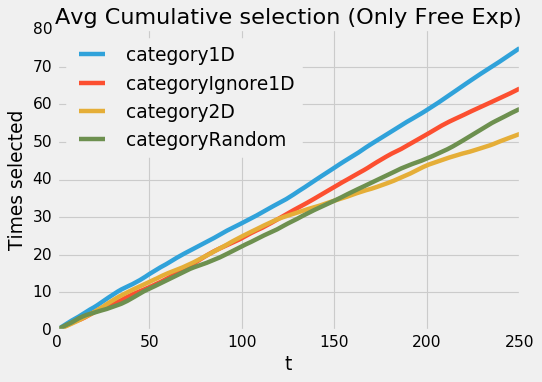

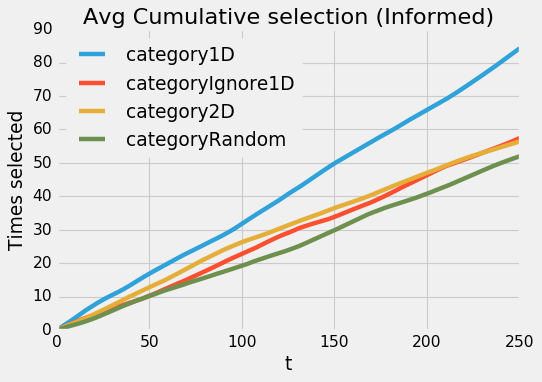

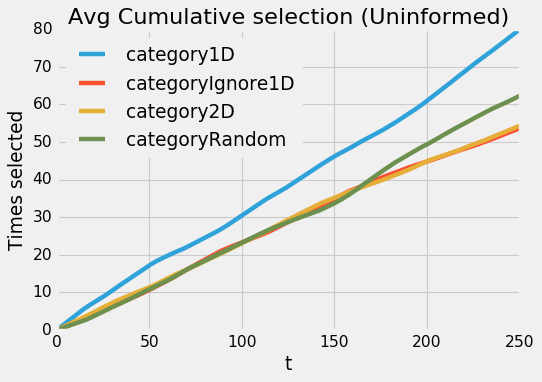

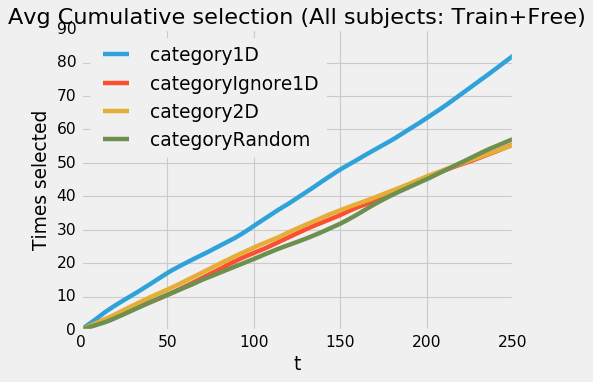

In [12]:
def plotCumSelec(arra, usersArr, title):
    
    # Count at each point in time number of occurrences up to that point and save it into a list
    def countInTime(arr, numOfValues):
        counts = []
        # trials = len(arr)+1
        # print(trials)
        # Only consider the official 250 trials
        trials = 251
        for i in range(trials):
            count = [(arr[:i] == e).sum() for e in range(numOfValues)]
            counts.append(count)
        return np.array(counts).T
    
    # Every element holds a matrix of the evolution of selection
    # Each column corresponds to a t where the max t=250 (it starts at t=0 though)
    # Each column corresponds to the cumulative selection of a task at time t
    cumCounts = []
    for u in range(usersArr):
        # Cumulative count for user u per task
        cumCounts.append( countInTime(arra[u][:,1], tasks) )

    # Dimensions 201x4x251 (201 users, 4 tasks, 251 time steps)
    # Get averages and std dev
    cumCounts = np.asarray(cumCounts)
    avg = np.mean(cumCounts, axis=0)
    std = np.std(cumCounts, axis=0)

    fig, ax = plt.subplots(figsize=(7, 5))

    for t in range(tasks):
        graph = ax.plot(avg[t,:], label=categories[t])

    #     color = graph[0].get_color()
    #     ax.plot(avg[t,:]+std[t,:], color, alpha=0.15)
    #     plt.plot(avg[t,:]-std[t,:], color, alpha=0.15)
    ax.legend(loc=0)
    ax.set_title(''.join(['Avg Cumulative selection ', title]))
    ax.set_ylabel('Times selected')
    ax.set_xlabel('t')

    plt.tight_layout()
    plt.show()

plotCumSelec(splitCsv, users, '(Only Free Exp)')

plotCumSelec(splitInf, uInf, '(Informed)')
plotCumSelec(splitUni, uUni, '(Uninformed)')
plotCumSelec(splitCsv2E, users2, '(All subjects: Train+Free)')

In [21]:
# uid, categories, correct
#print(splitInf)

def getCorrect(arr, usersArr):
    corrUser = []
    for u in range(usersArr):
        # Cumulative count for user u per task
        corrTask = []
        for t in range(tasks):
            # Calculate accuracy here since trials are dynamic
            correct = np.sum(arr[u][arr[u][:,1]==t, 2])
            total = np.shape(arr[u][arr[u][:,1]==t, 2])[0]
            #print(correct, total, correct/total)
            #corrTask.append(np.sum(arr[u][arr[u][:,1]==t, 2]))
            corrTask.append(correct/total)
        corrUser.append(corrTask)
    return np.asarray(corrUser)

corr = getCorrect(splitCsv, users)
corr[:,[1, 2]] = corr[:,[2, 1]]
# print(corr)
# print(np.nanmean(corr,axis=0))



In [22]:
# csvTest only contains the subset of results that were observed during the testing phase
# Split by condition
#csvTest = np.delete(csvTest, 2, axis = 1)
info = csvInt3[csvInt3[:,1]==0]
uninfo = csvInt3[csvInt3[:,1]==1]
# Delete condition column
info = np.delete(info, 1, axis=1)
uninfo = np.delete(uninfo, 1, axis=1)
# Split by users
splitInf = [info[info[:,0]==i] for i in np.unique(info[:,0])]
splitUni = [uninfo[uninfo[:,0]==i] for i in np.unique(uninfo[:,0])]

corrUni = getCorrect(splitUni, uUni)
corrInf = getCorrect(splitInf, uInf)
corrUni[:,[1, 2]] = corrUni[:,[2, 1]]
corrInf[:,[1, 2]] = corrInf[:,[2, 1]]
# print(corrUni)
# print(np.nanmean(corrUni,axis=0))

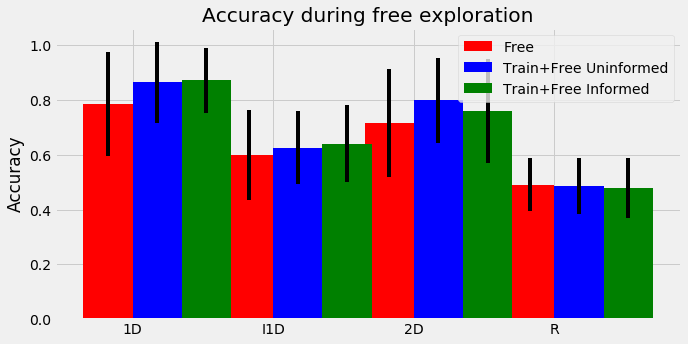

In [23]:
ind = np.arange(tasks)  # the x locations for the groups
width = 0.35       # the width of the bars

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(ind, np.nanmean(corr,axis=0), width, color='r', yerr=np.nanstd(corr,axis=0))

rects2 = ax.bar(ind+width, np.nanmean(corrUni,axis=0), width, color='b', yerr=np.nanstd(corrUni,axis=0))
rects3 = ax.bar(ind+width*2, np.nanmean(corrInf,axis=0), width, color='g', yerr=np.nanstd(corrInf,axis=0))

# add some text for labels, title and axes ticks
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy during free exploration')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1D', 'I1D', '2D', 'R'))

ax.legend((rects1[0], rects2[0], rects3[0]), ('Free', 'Train+Free Uninformed', 'Train+Free Informed'))


In [24]:
# TO CHECK
# (done) How many times do they even switch tasks? (cumulative in time, histogram to show individual persons)
# (done) How many times do they return to a task they already explored
# And how many separate periods there are in a given task?
# How long is the average number of of steps spent on a task

# The one with training supports what i said, it disencourages exploration. If you introduce training 
# with very clear feedback and no instructions then subjects may assume  this is about getting as many points as 
# possible. This is not curiousity driven behavior, they are not operating under ambiguous spontaneous
# self-defined objectives of information acquisition. Instead the mental frame of the experiment and prior 
# knowledge in life leads them to assume it is about performance related to the feedback they receive

## Other observations on exploration

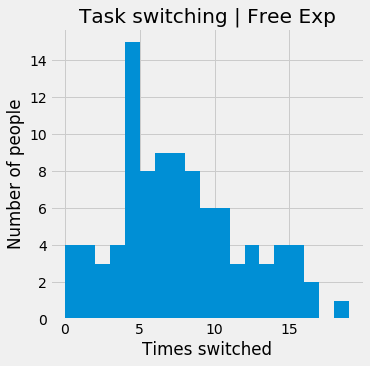

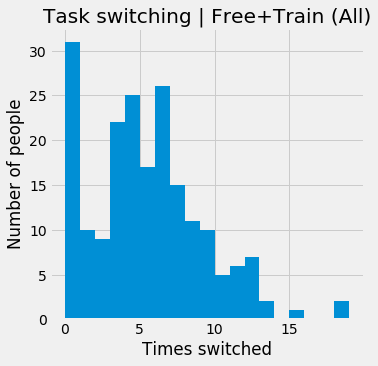

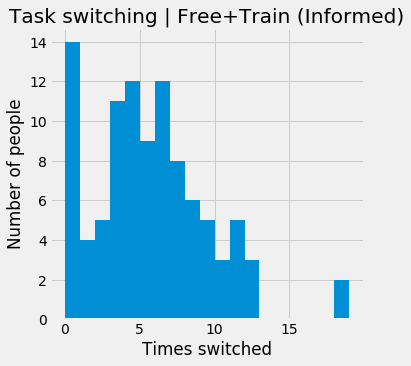

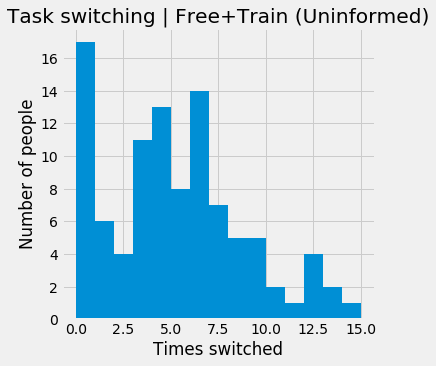

In [25]:
# Count the number of times subjects switched to another task during free exploration
def plotCountSwitchTask(arr, usersArr, title, outliers=False):
    fig, ax = plt.subplots(figsize=(5, 5))
    switchInExperiment = []
    switchInTimeUsers = []
    for u in range(usersArr):
        c = 0
        # Tracks number of task switching at each time step (per user)
        switchInTime = []
        # to homogenize truncate to the standard 250 trials
        for i in range(249): #(len(splitCsv[us][:,1])-1):
            # Check if the task selected now is the same as the task selected one step into the future
            # if that isn't the case then increase the switch counter
            # task has to be column 1
            if arr[u][i,1] != arr[u][i+1,1]:
                c+=1
            switchInTime.append(c)
        # Include or do not include outliers
        if outliers:
            switchInExperiment.append(c)
        elif c < 20:
            switchInExperiment.append(c)
            
        # This holds the evolution of task switching for all users
        switchInTimeUsers.append(switchInTime)
    plt.hist(switchInExperiment, bins=np.arange(np.max(switchInExperiment)+1))
    
    ax.legend()
    ax.set_title(''.join(['Task switching | ', title]))
    ax.set_xlabel('Times switched')
    ax.set_ylabel('Number of people')
    return switchInExperiment, np.asarray(switchInTimeUsers)

def plotEvolutionSwitchTask(arr):
    labels = ['Free Exp', 'Free+Train (All)', 'Free+Train (Informed)', 'Free+Train (Uninformed)']
    fig, ax = plt.subplots(figsize=(5, 5))
    # Go through every instance of the experiment
    for t in range(np.shape(arr)[1]):
        graph = ax.plot(arr[:,t], label=labels[t])
    
    ax.legend()
    ax.set_title('Avg Cumulative Task Switching')
    ax.set_ylabel('Times Switched')
    ax.set_xlabel('t')
    
sw, situF = plotCountSwitchTask(splitCsv, users, 'Free Exp', outliers=False)
#print(sw, np.mean(sw), np.max(sw))
sw, situFTA = plotCountSwitchTask(splitCsv2E, users2, 'Free+Train (All)', outliers=False)
sw, situFTI = plotCountSwitchTask(splitInf, uInf, 'Free+Train (Informed)', outliers=False)
#print(sw, np.mean(sw), np.max(sw))
#plt.hist(sw, bins=np.arange(np.max(sw)+1))
sw, situFTU = plotCountSwitchTask(splitUni, uUni, 'Free+Train (Uninformed)',outliers=False)
#print(sw, np.mean(sw), np.max(sw))
#plt.hist(sw, bins=np.arange(np.max(sw)+1))

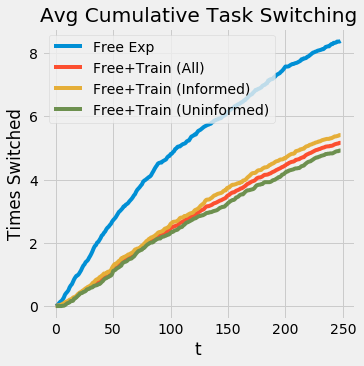

In [26]:
# Time a subject has switched tasks in time
evoSwitch = np.column_stack((np.mean(situF,axis=0), np.mean(situFTA,axis=0), np.mean(situFTI,axis=0), np.mean(situFTU,axis=0)))
plotEvolutionSwitchTask(evoSwitch)

## Going back to previously selected tasks

[ 1.39  1.34  1.42  1.5 ]
[ 0.72139303  0.70646766  0.67661692  0.78109453]
[ 0.75  0.74  0.7   0.87]
[ 0.69306931  0.67326733  0.65346535  0.69306931]


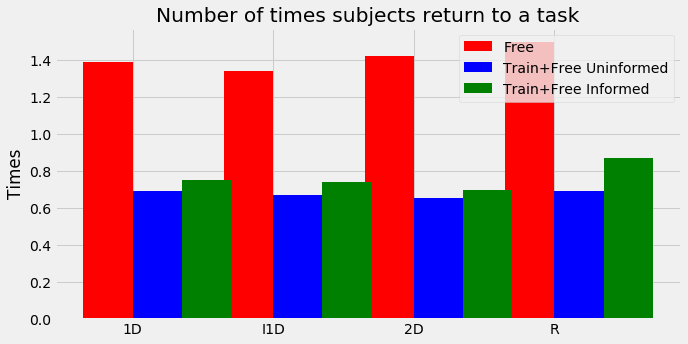

In [27]:
# us = 1
# ta = 3
# arr = splitCsv[us][:,1]
# print(arr)
# # get indices where task shows up
# ind = np.where(arr == ta)[0]
# print('indices',ind)
# # get difference between indices
# diff = np.diff(ind)
# print('Differences',diff)
# # get those where the difference is not 1 (i.e. they come from another task)
# numOfReturns = np.sum(diff > 1)
# print(numOfReturns)

def countReturns(arr, usersArr):
    # Stores returns per task per user
    retUser = []
    for u in range(usersArr):
        # stores return to a task
        retTask = []
        for t in range(tasks):
            # get indices where task shows up
            ind = np.where(arr[u][:,1] == t)[0]
            # get difference between indices
            diff = np.diff(ind)
            # count instances where the difference is not 1 (i.e. they come from another task)
            numOfReturns = np.sum(diff > 1)
            retTask.append(numOfReturns)
        retUser.append(retTask)
        
    print(np.mean(retUser,axis=0))
    
    return retUser


retF = countReturns(splitCsv, users)
retFTA = countReturns(splitCsv2E, users2)
retFTI = countReturns(splitInf, uInf)
retFTU = countReturns(splitUni, uUni)


ind = np.arange(tasks)  # the x locations for the groups
width = 0.35       # the width of the bars
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(ind, np.mean(retF,axis=0), width, color='r')
rects2 = ax.bar(ind+width, np.mean(retFTU,axis=0), width, color='b')
rects3 = ax.bar(ind+width*2, np.mean(retFTI,axis=0), width, color='g')
# add some text for labels, title and axes ticks
ax.set_ylabel('Times')
ax.set_title('Number of times subjects return to a task')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('1D', 'I1D', '2D', 'R'))
ax.legend((rects1[0], rects2[0], rects3[0]), ('Free', 'Train+Free Uninformed', 'Train+Free Informed'))


#Differences are small, but... could there be a case that once the random task is discovered it invites them 
#to try it more than the others?

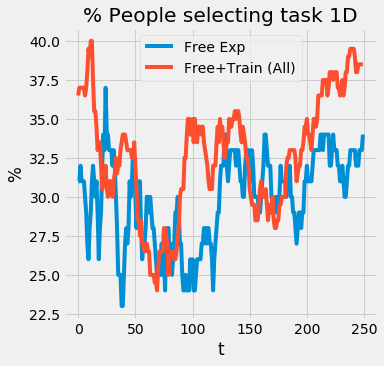

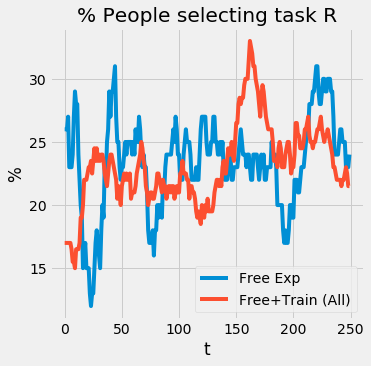

In [54]:
# How people are selecting after training

# plotCumSelec(splitInf, uInf, '(Informed)')
# plotCumSelec(splitUni, uUni, '(Uninformed)')
# plotCumSelec(splitCsv2E, users2, '(All subjects)')

def checkFirstOption(arr, usersArr, taskToCheck):
    selec = []
    for ti in range(250):
        c = 0
        for u in range(usersArr):
            if arr[u][ti,1] == taskToCheck:
                c+=1
        selec.append(c)
    return np.asarray(selec)
        
def plotEvolutionSel(arr, tas):
    labels = ['Free Exp', 'Free+Train (All)', 'Free+Train (Informed)', 'Free+Train (Uninformed)']
    ta = ['1D', 'I1D', '2D', 'R']
    fig, ax = plt.subplots(figsize=(5, 5))
    # Go through every instance of the experiment
    for t in range(np.shape(arr)[1]):
        graph = ax.plot(arr[:,t], label=labels[t])
    
    ax.legend()
    ax.set_title(''.join(['% People selecting task ', ta[tas]]))
    ax.set_ylabel('%')
    ax.set_xlabel('t')
    #ax.set_ylim([10,45])

for tas in [0,3]:
    selFTA = checkFirstOption(splitCsv2E, users2, tas)/2
    selFTI = checkFirstOption(splitInf, uInf, tas)
    selFTU = checkFirstOption(splitUni, uUni, tas)
    selF = checkFirstOption(splitCsv, users, tas)

    evoSel = np.column_stack((selF,selFTA))#(selF,selFTA,selFTI,selFTU))
    plotEvolutionSel(evoSel, tas)

In [135]:
# How long people spend on a task in separate periods (also in total?)

us = 0
ta = 0

spentTask = []
for u in range(2):#users):
    spentUser = []
    for t in range(tasks):
        arr = splitCsv[u][:,1]
        #print(arr)
        # get indices where task shows up
        ind = np.where(arr == t)[0]
        #print('indices',ind)

        # get difference between indices
        diff = np.diff(ind)
        #print('Differences',diff)

        # get those where the difference is not 1 (i.e. they come from another task)
        numOfReturns = np.sum(diff > 1)
        #print(numOfReturns)
        #print(diff > 1)
        # get boundaries: indices where is coming from another task
        bound = np.where(diff != 1)[0]
        #print(np.shape(bound))

        if len(bound) > 0:
            # concatenate start and concatenate total length
            bound = np.hstack((-1,bound,np.shape(diff)))
            # get differences
            length = np.diff(bound)
        else:
            length = len(ind)
        #print(bound)
        #print(np.where(diff != 1)[0])
        # # get differences
        # length = np.diff(bound)

        print(length, np.shape(length))
        #print(np.mean(length))
        spentUser.append(np.mean(length))
    spentTask.append(spentUser)


print(spentTask)

print(np.mean(spentTask,axis=0), np.std(spentTask,axis=0))
    
    
# TODO
# remove those that are 0, calculate average and dispersion for the task. 3 for instance is really bad. I want 
# to see the others

215 ()
[ 9 10  5  7] (4,)
35 ()
[26 34] (2,)
0 ()
[31  1 39] (3,)
0 ()
[22 43 23] (3,)
[array([ 215.  ,    7.75]), array([ 35.,  30.]), array([ 23.66666667]), array([ 29.33333333])]


IndexError: tuple index out of range